#Training the top  part of the VGG16 network

In [1]:
import numpy as np
import keras
from keras import backend as K
from keras.models import Sequential,Model
from keras.layers import Activation,Input
from keras.layers.core import Dense, Flatten,Dropout
from keras.optimizers import Adam
from keras.metrics import categorical_crossentropy
from keras.preprocessing.image import ImageDataGenerator
from keras.layers.normalization import BatchNormalization
from keras.layers.convolutional import *
from sklearn.metrics import confusion_matrix
import itertools
import matplotlib.pyplot as plt
import PIL
from PIL import Image

from keras.models import load_model
from keras import applications
from keras import optimizers



%matplotlib inline

Using TensorFlow backend.


In [2]:
# plots images with labels within jupyter notebook
#https://www.patreon.com/posts/code-for-keras-1-19266488
def plots(ims, figsize=(12,6), rows=1, interp=False, titles=None):
    if type(ims[0]) is np.ndarray:
        ims = np.array(ims).astype(np.uint8)
        if (ims.shape[-1] != 3):
            ims = ims.transpose((0,2,3,1))
    f = plt.figure(figsize=figsize)
    cols = len(ims)//rows if len(ims) % 2 == 0 else len(ims)//rows + 1
    for i in range(len(ims)):
        sp = f.add_subplot(rows, cols, i+1)
        sp.axis('Off')
        if titles is not None:
            sp.set_title(titles[i], fontsize=16)
        plt.imshow(ims[i], interpolation=None if interp else 'none')

In [3]:
train_path = 'Images/path_train'
valid_path = 'Images/path_valid'
test_path = 'Images/path_test'

In [4]:
train_batches = ImageDataGenerator().flow_from_directory(train_path,
                                                         target_size=(256,256),
                                                         classes=['agricultural','airplane','baseballdiamond','beach','buildings','chaparral','denseresidential','forest','freeway','golfcourse','harbor',
'intersection','mediumresidential','mobilehomepark','overpass','parkinglot','river','runway','sparseresidential','storagetanks','tenniscourt'], 
                                                         batch_size=10)
valid_batches = ImageDataGenerator().flow_from_directory(valid_path,
                                                         target_size=(256,256),
                                                         classes=['agricultural','airplane','baseballdiamond','beach','buildings','chaparral','denseresidential','forest','freeway','golfcourse','harbor',
'intersection','mediumresidential','mobilehomepark','overpass','parkinglot','river','runway','sparseresidential','storagetanks','tenniscourt'], 
                                                         batch_size=10)
test_batches = ImageDataGenerator().flow_from_directory(test_path,
                                                        target_size=(256,256), 
                                                        classes=['agricultural','airplane','baseballdiamond','beach','buildings','chaparral','denseresidential','forest','freeway','golfcourse','harbor',
'intersection','mediumresidential','mobilehomepark','overpass','parkinglot','river','runway','sparseresidential','storagetanks','tenniscourt'],
                                                        batch_size=10)

Found 43680 images belonging to 21 classes.
Found 2730 images belonging to 21 classes.
Found 2730 images belonging to 21 classes.


In [5]:
imgs, labels = next(train_batches)

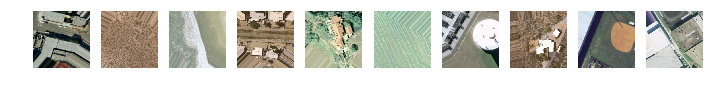

In [6]:
plots(imgs)

In [7]:
# build the VGG16 network
# build the VGG16 network

input_tensor = Input(shape=(256,256,3))
model = applications.VGG16(weights='imagenet', include_top=False,input_tensor=input_tensor)

print('Model loaded.')



Model loaded.


In [8]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 256, 256, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 256, 256, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 256, 256, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 128, 128, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 128, 128, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 128, 128, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 64, 64, 128)       0         
__________

In [13]:
 #build a classifier model to put on top of the convolutional model
    
top_model = Sequential()
top_model.add(Flatten(input_shape=model.output_shape[1:]))
top_model.add(Dense(256, activation='relu'))
top_model.add(Dropout(0.5))

top_model.add(Dense(21, activation='softmax'))

In [14]:
top_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_3 (Flatten)          (None, 32768)             0         
_________________________________________________________________
dense_5 (Dense)              (None, 256)               8388864   
_________________________________________________________________
dropout_3 (Dropout)          (None, 256)               0         
_________________________________________________________________
dense_6 (Dense)              (None, 21)                5397      
Total params: 8,394,261
Trainable params: 8,394,261
Non-trainable params: 0
_________________________________________________________________


In [15]:
# set the first 25 layers (up to the last conv block)

# to non-trainable (weights will not be updated)

for layer in model.layers[:25]:

    layer.trainable = False

In [16]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 256, 256, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 256, 256, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 256, 256, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 128, 128, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 128, 128, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 128, 128, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 64, 64, 128)       0         
__________

In [19]:
# add the model on top of the convolutional base
new_model = Sequential()
new_model.add(model)
new_model.add(top_model)

new_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Model)                (None, 8, 8, 512)         14714688  
_________________________________________________________________
sequential_3 (Sequential)    (None, 21)                8394261   
Total params: 23,108,949
Trainable params: 8,394,261
Non-trainable params: 14,714,688
_________________________________________________________________


In [21]:
new_model.compile(Adam(lr=.0001), loss='categorical_crossentropy', metrics=['accuracy'])

In [24]:
history_new_model_01=new_model.fit_generator(train_batches,steps_per_epoch=208, 
                    validation_data=valid_batches, epochs=750, verbose=2)
#validation_steps=32, 


Epoch 1/750
 - 47s - loss: 3.8318 - acc: 0.6880 - val_loss: 2.1152 - val_acc: 0.7971
Epoch 2/750
 - 42s - loss: 3.1200 - acc: 0.6952 - val_loss: 1.6994 - val_acc: 0.7989
Epoch 3/750
 - 42s - loss: 2.2818 - acc: 0.6976 - val_loss: 0.8724 - val_acc: 0.8000
Epoch 4/750
 - 41s - loss: 1.4347 - acc: 0.7120 - val_loss: 0.7748 - val_acc: 0.8029
Epoch 5/750
 - 41s - loss: 1.4224 - acc: 0.6841 - val_loss: 0.8504 - val_acc: 0.7908
Epoch 6/750
 - 40s - loss: 1.2708 - acc: 0.7154 - val_loss: 0.6865 - val_acc: 0.8212
Epoch 7/750
 - 40s - loss: 1.2482 - acc: 0.7183 - val_loss: 0.6715 - val_acc: 0.8128
Epoch 8/750
 - 39s - loss: 1.2192 - acc: 0.7135 - val_loss: 0.6085 - val_acc: 0.8253
Epoch 9/750
 - 38s - loss: 1.1214 - acc: 0.7351 - val_loss: 0.6184 - val_acc: 0.8289
Epoch 10/750
 - 38s - loss: 1.1552 - acc: 0.7327 - val_loss: 0.5839 - val_acc: 0.8366
Epoch 11/750
 - 40s - loss: 1.0268 - acc: 0.7404 - val_loss: 0.5370 - val_acc: 0.8385
Epoch 12/750
 - 37s - loss: 0.9033 - acc: 0.7548 - val_loss: 0.

Epoch 97/750
 - 35s - loss: 0.3336 - acc: 0.9173 - val_loss: 0.3562 - val_acc: 0.9238
Epoch 98/750
 - 35s - loss: 0.2747 - acc: 0.9212 - val_loss: 0.3666 - val_acc: 0.9253
Epoch 99/750
 - 35s - loss: 0.3190 - acc: 0.9173 - val_loss: 0.3200 - val_acc: 0.9300
Epoch 100/750
 - 35s - loss: 0.3103 - acc: 0.9159 - val_loss: 0.4062 - val_acc: 0.9114
Epoch 101/750
 - 35s - loss: 0.3665 - acc: 0.9159 - val_loss: 0.4781 - val_acc: 0.9201
Epoch 102/750
 - 35s - loss: 0.3196 - acc: 0.9221 - val_loss: 0.3932 - val_acc: 0.9231
Epoch 103/750
 - 35s - loss: 0.3596 - acc: 0.9149 - val_loss: 0.4113 - val_acc: 0.9253
Epoch 104/750
 - 35s - loss: 0.3799 - acc: 0.9139 - val_loss: 0.3926 - val_acc: 0.9308
Epoch 105/750
 - 35s - loss: 0.3535 - acc: 0.9269 - val_loss: 0.3979 - val_acc: 0.9242
Epoch 106/750
 - 35s - loss: 0.3737 - acc: 0.9216 - val_loss: 0.3845 - val_acc: 0.9333
Epoch 107/750
 - 35s - loss: 0.3286 - acc: 0.9178 - val_loss: 0.4004 - val_acc: 0.9253
Epoch 108/750
 - 35s - loss: 0.3604 - acc: 0.9

Epoch 192/750
 - 35s - loss: 0.2016 - acc: 0.9514 - val_loss: 0.4227 - val_acc: 0.9359
Epoch 193/750
 - 35s - loss: 0.2654 - acc: 0.9442 - val_loss: 0.4344 - val_acc: 0.9366
Epoch 194/750
 - 35s - loss: 0.1797 - acc: 0.9567 - val_loss: 0.3903 - val_acc: 0.9414
Epoch 195/750
 - 35s - loss: 0.1583 - acc: 0.9534 - val_loss: 0.4321 - val_acc: 0.9348
Epoch 196/750
 - 35s - loss: 0.2669 - acc: 0.9428 - val_loss: 0.3751 - val_acc: 0.9381
Epoch 197/750
 - 35s - loss: 0.2499 - acc: 0.9389 - val_loss: 0.4090 - val_acc: 0.9326
Epoch 198/750
 - 35s - loss: 0.2354 - acc: 0.9495 - val_loss: 0.3827 - val_acc: 0.9418
Epoch 199/750
 - 35s - loss: 0.2072 - acc: 0.9486 - val_loss: 0.4059 - val_acc: 0.9392
Epoch 200/750
 - 35s - loss: 0.2093 - acc: 0.9529 - val_loss: 0.4429 - val_acc: 0.9381
Epoch 201/750
 - 35s - loss: 0.1620 - acc: 0.9558 - val_loss: 0.4452 - val_acc: 0.9381
Epoch 202/750
 - 35s - loss: 0.2167 - acc: 0.9486 - val_loss: 0.3618 - val_acc: 0.9392
Epoch 203/750
 - 35s - loss: 0.2029 - acc: 

Epoch 287/750
 - 35s - loss: 0.1423 - acc: 0.9663 - val_loss: 0.3749 - val_acc: 0.9421
Epoch 288/750
 - 35s - loss: 0.2024 - acc: 0.9524 - val_loss: 0.3680 - val_acc: 0.9454
Epoch 289/750
 - 35s - loss: 0.1782 - acc: 0.9654 - val_loss: 0.4772 - val_acc: 0.9374
Epoch 290/750
 - 35s - loss: 0.2300 - acc: 0.9534 - val_loss: 0.4289 - val_acc: 0.9403
Epoch 291/750
 - 35s - loss: 0.1787 - acc: 0.9601 - val_loss: 0.3981 - val_acc: 0.9388
Epoch 292/750
 - 35s - loss: 0.2479 - acc: 0.9500 - val_loss: 0.4399 - val_acc: 0.9366
Epoch 293/750
 - 35s - loss: 0.1982 - acc: 0.9562 - val_loss: 0.3658 - val_acc: 0.9407
Epoch 294/750
 - 35s - loss: 0.2312 - acc: 0.9553 - val_loss: 0.3997 - val_acc: 0.9403
Epoch 295/750
 - 35s - loss: 0.1758 - acc: 0.9577 - val_loss: 0.3965 - val_acc: 0.9418
Epoch 296/750
 - 35s - loss: 0.1992 - acc: 0.9615 - val_loss: 0.4152 - val_acc: 0.9429
Epoch 297/750
 - 35s - loss: 0.1493 - acc: 0.9620 - val_loss: 0.3980 - val_acc: 0.9462
Epoch 298/750
 - 35s - loss: 0.2052 - acc: 

Epoch 382/750
 - 35s - loss: 0.1957 - acc: 0.9687 - val_loss: 0.4885 - val_acc: 0.9421
Epoch 383/750
 - 35s - loss: 0.2365 - acc: 0.9663 - val_loss: 0.4886 - val_acc: 0.9447
Epoch 384/750
 - 35s - loss: 0.1982 - acc: 0.9683 - val_loss: 0.4943 - val_acc: 0.9429
Epoch 385/750
 - 35s - loss: 0.1796 - acc: 0.9683 - val_loss: 0.4501 - val_acc: 0.9447
Epoch 386/750
 - 35s - loss: 0.1186 - acc: 0.9731 - val_loss: 0.4768 - val_acc: 0.9480
Epoch 387/750
 - 35s - loss: 0.1540 - acc: 0.9707 - val_loss: 0.4392 - val_acc: 0.9502
Epoch 388/750
 - 35s - loss: 0.1694 - acc: 0.9712 - val_loss: 0.4792 - val_acc: 0.9473
Epoch 389/750
 - 35s - loss: 0.1517 - acc: 0.9712 - val_loss: 0.5075 - val_acc: 0.9407
Epoch 390/750
 - 35s - loss: 0.1514 - acc: 0.9731 - val_loss: 0.5371 - val_acc: 0.9388
Epoch 391/750
 - 35s - loss: 0.1677 - acc: 0.9745 - val_loss: 0.5236 - val_acc: 0.9348
Epoch 392/750
 - 35s - loss: 0.1594 - acc: 0.9692 - val_loss: 0.4503 - val_acc: 0.9443
Epoch 393/750
 - 35s - loss: 0.1599 - acc: 

Epoch 477/750
 - 35s - loss: 0.1545 - acc: 0.9678 - val_loss: 0.5029 - val_acc: 0.9381
Epoch 478/750
 - 35s - loss: 0.1387 - acc: 0.9687 - val_loss: 0.4721 - val_acc: 0.9403
Epoch 479/750
 - 35s - loss: 0.1376 - acc: 0.9721 - val_loss: 0.4490 - val_acc: 0.9403
Epoch 480/750
 - 35s - loss: 0.1283 - acc: 0.9712 - val_loss: 0.4438 - val_acc: 0.9447
Epoch 481/750
 - 35s - loss: 0.1100 - acc: 0.9812 - val_loss: 0.4215 - val_acc: 0.9476
Epoch 482/750
 - 35s - loss: 0.1178 - acc: 0.9736 - val_loss: 0.4280 - val_acc: 0.9458
Epoch 483/750
 - 35s - loss: 0.0984 - acc: 0.9788 - val_loss: 0.5152 - val_acc: 0.9381
Epoch 484/750
 - 35s - loss: 0.1788 - acc: 0.9692 - val_loss: 0.4849 - val_acc: 0.9355
Epoch 485/750
 - 35s - loss: 0.1218 - acc: 0.9750 - val_loss: 0.3784 - val_acc: 0.9476
Epoch 486/750
 - 35s - loss: 0.1319 - acc: 0.9721 - val_loss: 0.4345 - val_acc: 0.9447
Epoch 487/750
 - 35s - loss: 0.1509 - acc: 0.9760 - val_loss: 0.4015 - val_acc: 0.9447
Epoch 488/750
 - 35s - loss: 0.1732 - acc: 

Epoch 572/750
 - 35s - loss: 0.1357 - acc: 0.9740 - val_loss: 0.4863 - val_acc: 0.9465
Epoch 573/750
 - 35s - loss: 0.1098 - acc: 0.9774 - val_loss: 0.4580 - val_acc: 0.9491
Epoch 574/750
 - 35s - loss: 0.1212 - acc: 0.9774 - val_loss: 0.4369 - val_acc: 0.9498
Epoch 575/750
 - 35s - loss: 0.1463 - acc: 0.9750 - val_loss: 0.4391 - val_acc: 0.9465
Epoch 576/750
 - 35s - loss: 0.1659 - acc: 0.9745 - val_loss: 0.3893 - val_acc: 0.9484
Epoch 577/750
 - 35s - loss: 0.1423 - acc: 0.9726 - val_loss: 0.3938 - val_acc: 0.9484
Epoch 578/750
 - 35s - loss: 0.1682 - acc: 0.9721 - val_loss: 0.4412 - val_acc: 0.9440
Epoch 579/750
 - 35s - loss: 0.1019 - acc: 0.9774 - val_loss: 0.4003 - val_acc: 0.9480
Epoch 580/750
 - 35s - loss: 0.0975 - acc: 0.9755 - val_loss: 0.4175 - val_acc: 0.9458
Epoch 581/750
 - 35s - loss: 0.1009 - acc: 0.9827 - val_loss: 0.3948 - val_acc: 0.9505
Epoch 582/750
 - 35s - loss: 0.0849 - acc: 0.9774 - val_loss: 0.4429 - val_acc: 0.9476
Epoch 583/750
 - 35s - loss: 0.1112 - acc: 

Epoch 667/750
 - 35s - loss: 0.0895 - acc: 0.9798 - val_loss: 0.3869 - val_acc: 0.9560
Epoch 668/750
 - 35s - loss: 0.1336 - acc: 0.9774 - val_loss: 0.4581 - val_acc: 0.9495
Epoch 669/750
 - 35s - loss: 0.1383 - acc: 0.9808 - val_loss: 0.4248 - val_acc: 0.9498
Epoch 670/750
 - 35s - loss: 0.1251 - acc: 0.9784 - val_loss: 0.4368 - val_acc: 0.9516
Epoch 671/750
 - 35s - loss: 0.1019 - acc: 0.9856 - val_loss: 0.4071 - val_acc: 0.9557
Epoch 672/750
 - 35s - loss: 0.1357 - acc: 0.9793 - val_loss: 0.3989 - val_acc: 0.9542
Epoch 673/750
 - 35s - loss: 0.1583 - acc: 0.9740 - val_loss: 0.4129 - val_acc: 0.9520
Epoch 674/750
 - 35s - loss: 0.1407 - acc: 0.9716 - val_loss: 0.4243 - val_acc: 0.9531
Epoch 675/750
 - 35s - loss: 0.1161 - acc: 0.9837 - val_loss: 0.4647 - val_acc: 0.9531
Epoch 676/750
 - 35s - loss: 0.1838 - acc: 0.9702 - val_loss: 0.4542 - val_acc: 0.9505
Epoch 677/750
 - 35s - loss: 0.1754 - acc: 0.9774 - val_loss: 0.4470 - val_acc: 0.9509
Epoch 678/750
 - 35s - loss: 0.1261 - acc: 

In [ ]:
##pop function
def pop(model):
    '''Removes a layer instance on top of the layer stack.
    This code is thanks to @joelthchao https://github.com/fchollet/keras/issues/2371#issuecomment-211734276
    '''
    if not model.outputs:
        raise Exception('Sequential model cannot be popped: model is empty.')
    else:
        model.layers.pop()
        if not model.layers:
            model.outputs = []
            model.inbound_nodes = []
            model.outbound_nodes = []
        else:
            model.layers[-1].outbound_nodes = []
            model.outputs = [model.layers[-1].output]
        model.built = False

    return model

In [ ]:
pop(model_last_layer)

In [ ]:
for layer in model_last_layer.layers:
    layer.trainable = False

In [ ]:
model_last_layer.add(Dense(21, activation='softmax'))

model_last_layer.summary()

In [ ]:
model_last_layer.compile(Adam(lr=.0001), loss='categorical_crossentropy', metrics=['accuracy'])

In [ ]:
model_last_layer.fit_generator(train_batches,steps_per_epoch=208, 
                    validation_data=valid_batches, epochs=600, verbose=2)
#validation_steps=32, 


In [ ]:
model_last_layer.save('model_last_layer.h5')

In [ ]:
from keras.callbacks import History
import json

In [ ]:
model_last_layer.save_weights('model_last_layer_WEIGHTS.h5')

with open('model_last_layer_ARCHITECTURE.json','w') as f:
          f.write(model_last_layer.to_json())

In [ ]:
history_model_last_layer=keras.callbacks.History()

In [ ]:
type(history_model_last_layer)

In [ ]:
history_model_last_layer.history['loss']

In [ ]:
model_last3_layer = Sequential()
for layer in vgg16_model.layers:
    model_last3_layer.add(layer)


In [ ]:
for layer in model_last3_layer.layers:
    print(layer.name)
    

In [ ]:
model_last3_layer.layers.pop()


In [ ]:
model_last3_layer.add(Dense(9, activation='softmax'))

model_last3_layer.summary()

In [ ]:
model_last3_layer.compile(Adam(lr=.0001), loss='categorical_crossentropy', metrics=['accuracy'])
model_last3_layer.fit_generator(train_batches,steps_per_epoch=520, 
                    validation_data=valid_batches, validation_steps=32, epochs=5, verbose=2)

In [ ]:
test_imgs, test_labels = next(test_batches)
plots(test_imgs, titles=test_labels)

In [ ]:
predictions = model.predict_generator(test_batches, steps=8, verbose=0)

In [ ]:
#https://www.youtube.com/watch?v=km7pxKy4UHU&list=PLZbbT5o_s2xrwRnXk_yCPtnqqo4_u2YGL&index=8
def plot_confusion_matrix(cm,classes, normalize=False, title='Confusion Matrix', cmap=plt.cm.Blues):
    plt.imshow(cm,interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks=np.arange(len(classes))
    plt.xticks(tick_marks,classes,rotation=45)
    plt.yticks(tick_marks,classes)
    
    if normalize:
        cm=cm.astype('float') /cum.sum(axis=1)[:,np.newaxis]
        print('Normalized Confusion Matrix')
    
    else:
        print('Confusion Matrix Without Normalization')
    
    print(cm)
    
    thresh=cm.max()/2.
    
    for i,j in itertools.product(range(cm.shape[0]),range(cm.shape[1])):
        plt.text(j,i,cm[i,j], horizontalalignment='center', color='white' if cm[i,j]>thresh else 'black')
    
    plt.tight_layout()
    plt.ylabel('True_Label')
    plt.xlabel('Presicted_Label')

In [ ]:
cm_plot_labels = ['agricultural', 'beach', 'buildings', 'chaperral', 'forest', 'freeway', 'harbor','intersection','river']
plot_confusion_matrix(cm, cm_plot_labels, title='Confusion Matrix')

In [ ]:
model_last_layer.summary()